## Libraries

In [1]:
import networkx as nx
import os
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import ast

# allowing the plot in line for seaborn
%matplotlib inline
plt.style.use('seaborn')

# enabling outlines line in histogram 
plt.rcParams["patch.force_edgecolor"] = True

## Function

In [111]:
def save_img(title, name):    
    plt.savefig(f'/Users/villons/Desktop/echo-chamers/src/analysis_images/{name}/{title}.png', 
                dpi = 300, quality = 95, format = 'png', pad_inches = 1000)
    
def community_pie_chart(graph, comm_type, name, study):
    
    communities = dict()
    for node in graph.nodes(data=True):
        if not(f'Comunità: {node[1][comm_type]}' in communities):
            communities[f'Comunità: {node[1][comm_type]}'] = 1
        else:
            communities[f'Comunità: {node[1][comm_type]}'] += 1
            
            
    com = list(communities.keys())
    com_comp = list(communities.values())
    colors = ['#0045b5', '#b50000']
    if com[0] != 'Comunità: 1':
        com[0], com[1] = com[1], com[0]
        com_comp[0], com_comp[1] = com_comp[1], com_comp[0]

    print(communities)
    
    fig, ax = plt.subplots()
    ax.pie(com_comp, labels = com, explode = [0, 0.1], shadow=True,
        startangle = 90, colors = colors, wedgeprops={'edgecolor': 'black'}, autopct='%1.1f%%')
    ax.set_title(f'Suddivisione community per {name}')
    save_img(f'Suddivisione community per {name}', study)
    plt.show() 
        
def create_graph_df(graph):
    graph_df = pd.DataFrame(columns=['username', 'sentiment', 'weightComm', 'sentimentComm', 'topicComm', 'hybridComm', 'tweetTopic'])
    for node in tqdm(graph.nodes(data=True)):
        new_row = [node[0], node[1]['sentiment'], node[1]['weightComm'], node[1]['sentimentComm'],
                   node[1]['topicComm'], node[1]['hybridComm'], node[1]['tweetTopic']]
        graph_df.loc[len(graph_df)] = new_row
    return graph_df

def add_to_dictionary(dictionary, key):
    if key in dictionary:
        dictionary[key] += 1
    else:
        dictionary[key] = 1
    return dictionary

def plot_degree_distribution(graph, name, opt):
    degree_distribution = pd.DataFrame(columns=['degree_value', 'community', 'towards', 'placeholder'])
        
    for node in tqdm(graph.nodes(data=True)):
        if opt == 0:
            title = f'Distribuzione per {name}'
                
            out_edges = list(graph.out_edges(node[0], data=True))
            in_edges = list(graph.in_edges(node[0], data=True))
            out_degree_values = 0
            in_degree_values = 0
            
            comm = node[1]['sentimentComm']
            
            for edge in out_edges:
                out_degree_values += edge[2]['weight']

            for edge in in_edges:
                in_degree_values += edge[2]['weight']

            degree_distribution.loc[len(degree_distribution)] = [out_degree_values, comm, 'outdegree', '']
            degree_distribution.loc[len(degree_distribution)] = [in_degree_values, comm, 'indegree', '']
        else:
            graph_name = graph.name.split('graph')[1]
            title = f'Distribuzione per {graph_name}'
            edges = list(graph.edges(node[0], data=True))
            edge_degree = 0
            comm = node[1]['weightComm']
            for edge in edges:
                edge_degree += edge[2]['weight']
            degree_distribution.loc[len(degree_distribution)] = [edge_degree, comm, 'total_degree', '']
            
    degree_value = degree_distribution['degree_value']
    removed_outliers = degree_value.between(degree_value.quantile(.25), degree_value.quantile(0.85))
    index_names = degree_distribution[~removed_outliers].index
    degree_distribution.drop(index_names, inplace=True)
    degree_distribution['degree_value'] = degree_distribution['degree_value'].apply(lambda x: float(x))
    

    fig, ax = plt.subplots()
    if opt == 1:
        x_value = 'placeholder'
    else:
        x_value = 'towards'
    
    ax = sns.violinplot(x=x_value, y='degree_value', hue='community', data=degree_distribution, split=True, scale='count', bw=0.1)
    ax.set_title(title)
    ax.set_xlabel('Distribuzione di grado')
    ax.set_ylabel('Numero di tweets')
    ax.legend(title='Community')
    save_img(title, name)
    plt.show()
    
def plot_sentiment_distribution(compact_graph, name, sentiment_df):
    
    fig, ax = plt.subplots()
    ax = sns.distplot(sentiment_df['sentiment'], hist=False, label='Sentimento su intero grafo')
    title = f'Distribuzione sentiment su grafo {name}'
    ax.set_title(title)
    ax.set_xlabel('Score sentimento')
    ax.set_ylabel('Distribuzione probabilità')
    ax.legend()
    save_img(title, name)
    plt.show()
    
    columns = sentiment_df.columns[2:len(sentiment_df.columns)-1]
    
    titles = ['strutturale', 'sentiment', 'topic', 'hybrid']
    index = 0
    for column in columns:
        title = f'Distribuzione sentimento nelle communities dato approccio {titles[index]}'
        sentiment_df_weight_0 = sentiment_df.query(f'{column} == 0')
        sentiment_df_weight_1 = sentiment_df.query(f'{column} == 1')
        fig, ax = plt.subplots()
        ax = sns.distplot(sentiment_df_weight_0['sentiment'], hist=False, label='Sentimento nella community 0')
        ax = sns.distplot(sentiment_df_weight_1['sentiment'], hist=False, label='Sentimento nella community 1')
        ax.set_title(title)
        ax.set_xlabel('Score sentimento')
        ax.set_ylabel('Distribuzione probabilità')
        ax.legend()
        save_img(title, name)
        plt.show()
        index += 1
        
def delete_outliers(dataset, field):
    
    dataset_value = dataset[field]
    removed_outliers = dataset_value.between(dataset_value.quantile(.25), dataset_value.quantile(0.85))
    index_names = dataset[~removed_outliers].index
    dataset = dataset.drop(index_names)
    return dataset
    
def plot_snsdist(metadata, field):
    metadata_no_out = delete_outliers(metadata, field)
    fig, ax = plt.subplots()
    com_0 = metadata_no_out.query('community == "0"')
    com_1 = metadata_no_out.query('community == "1"')
    
    ax = sns.distplot(com_0[field], hist=False, label=f'{field} community 0')
    ax = sns.distplot(com_1[field], hist=False, label=f'{field} community 1')
    
    title = f'Valutazione {field}'
    ax.set_title(title)
    ax.set_xlabel(f'{field}')
    ax.set_ylabel(f'Distribuzione di probabiltà')
    ax.legend()
    save_img(title, 'COVID-19')
    plt.show()
    
def get_metadata():
    files = os.listdir()
    
    if 'complete_metadata.csv' not in files:
        medatada_df = pd.DataFrame(columns=['username', 'created', 'defaultProfile',
                                            'DefaultImage', 'description', 'numLikes', 
                                            'numFollowers', 'numFollowing', 'numGroups', 
                                            'location', 'numStatuses', 'verified', 'community',
                                            'sentiment', 'placeholder'])
        for node in tqdm(covid_complete.nodes(data=True)):
            row = [node[0]]
            if covid_metadata.nodes[node[0]] != {}:
                for medatada in covid_metadata.nodes[node[0]]:
                    row += [covid_metadata.nodes[node[0]][medatada]]
            else:
                row += [np.nan]*(len(medatada_df.columns)-4)

            row += [node[1]['sentimentComm']]
            row += [node[1]['sentiment']]
            row += ['']
            medatada_df.loc[len(medatada_df)] = row
        medatada_df.to_csv('./complete_metadata.csv', index=False, encoding='utf-8')
    else:
        medatada_df = pd.read_csv('./complete_metadata.csv', dtype=str)
    
    for field in ['numFollowers', 'numLikes', 'numFollowing', 'numGroups', 'numStatuses']:
        medatada_df[field] = medatada_df[field].apply(lambda x: float(x))
    
    medatada_df['placeholder'] = [' ']*len(medatada_df)
    medatada_df.dropna(axis='index', how='any', inplace=True)
    
    medatada_df['created'] = pd.to_datetime(medatada_df['created'], format='%Y-%m-%d')
    
    return medatada_df


def verified_pie_chart(community, metadata_df):
    comm = metadata.query(f'community == "{community}"')
    verified_dict = dict(comm.verified.value_counts())
    del verified_dict['-1']
    verified_dict = dict(sorted(verified_dict.items()))
    title = f'Account verificati per la community {community}'
    
    verified = list(verified_dict.keys())
    count_ver = list(verified_dict.values())
    colors = ['#0045b5', '#b50000']
    
    fig, ax = plt.subplots()
    ax.pie(count_ver, labels = verified, explode = [0, 0.1], shadow=True,
        startangle = 90, colors = colors, wedgeprops={'edgecolor': 'black'}, autopct='%1.1f%%')
    ax.set_title(title)
    save_img(title, 'COVID-19')
    plt.show() 
    
def default_pie_chart(community, metadata_df, element, opt = 0):
    comm = metadata.query(f'community == "{community}"')
    if element == 'defaultProfile':
        default_dict = dict(comm.defaultProfile.value_counts())
        title = f'Profilo di default per utenti community {community}'
    elif element == 'DefaultImage':
        default_dict = dict(comm.DefaultImage.value_counts())
        title = f'Immagine di default per utenti community {community}'
        
    if opt == 1:
        title = f'{title} dati account 2020'
    
    if '-1' in default_dict:
        del default_dict['-1']
    default_dict = dict(sorted(default_dict.items()))
    
    verified = list(default_dict.keys())
    count_ver = list(default_dict.values())
    colors = ['#0045b5', '#b50000']
    
    fig, ax = plt.subplots()
    ax.pie(count_ver, labels = verified, explode = [0, 0.1], shadow=True,
        startangle = 90, colors = colors, wedgeprops={'edgecolor': 'black'}, autopct='%1.1f%%')
    ax.set_title(title)
    save_img(title, 'COVID-19')
    plt.show() 
    
def topic_distribution(graph_df, name):
    
    titles = ['strutturale', 'sentiment', 'topic', 'hybrid']
    cont = 0
    
    comm_types = list(graph_df.columns)[2:6]
    
    for comm_type in comm_types:
        topic_cont = dict()
        topic_cont_0 = dict()
        topic_cont_1 = dict()
        for _, row in graph_df.iterrows():
            topics = ast.literal_eval(row['tweetTopic'])
            community = row[f'{comm_type}']
            for topic in topics:
                topic_cont = add_to_dictionary(topic_cont, topic)
                if community == 0:
                    topic_cont_0 = add_to_dictionary(topic_cont_0, topic)
                else:
                    topic_cont_1 = add_to_dictionary(topic_cont_1, topic)
                    
                
        topic_cont = dict(sorted(topic_cont.items()))
        topic_cont_0 = dict(sorted(topic_cont_0.items()))
        topic_cont_1 = dict(sorted(topic_cont_1.items()))


        title = f'Distribuzione topic con approccio {titles[cont]}'

        width = 0.25
        fig, ax = plt.subplots()
        fig.set_size_inches(18.5, 10.5)
        x_indexes = np.arange(1, len(topic_cont)+1)
        ax.bar(x_indexes - width, topic_cont.values(), width = width, color = '#444444', label = 'Su tutto il grafo')
        ax.bar(x_indexes, topic_cont_0.values(), width = width, color = '#5a7d9a', label = 'Community 0')
        ax.bar(x_indexes + width, topic_cont_1.values(), width = width, color = '#adad3b', label = 'Community 1')
        plt.xticks(ticks=x_indexes, labels=x_indexes)
        ax.legend()
        ax.set_xlabel('ID dei topic')
        ax.set_ylabel('tweet associati ai topic')
        ax.set_title(title)
        
        cont += 1

        save_img(title, name)
        plt.show()
        
def plot_hist_2020(meta_2020):
    com_0 = meta_2020.query('community == "0"')
    com_1 = meta_2020.query('community == "1"')
    
    title = 'Numerosità account creati nel 2020 in funzione delle community'
    fig, ax = plt.subplots()
    x_indexes = np.arange(0, 2)
    ax.bar(x_indexes, [len(com_0), len(com_1)], width = 0.5)
    plt.xticks(ticks=x_indexes, labels=x_indexes)
    ax.legend()
    ax.set_xlabel('Community')
    ax.set_ylabel('# Account creati nel 2020')
    ax.set_title(title)
    save_img(title, 'COVID-19')
    plt.show()
    
def plot_join_plot(field1, fiel2, metadata, title):

    fig, ax = plt.subplots()
    ax.set_xlabel(field1)
    ax.set_ylabel(fiel2)
    ax.set_title(title)
    ax = sns.jointplot(x=field1, y=fiel2, data=metadata, color='green', kind='reg')
    #save_img(title, 'COVID-19')
    plt.show()

def delete_outliers(field, df):
    values = df[field]
    removed_outliers = values.between(values.quantile(.25), values.quantile(0.75))
    index_names = df[~removed_outliers].index
    df.drop(index_names, inplace=True)
    return df
    
def join_plot(field1, field2, metadata, title):
    
    metadata_df = delete_outliers(field1, metadata)
    metadata_df = delete_outliers(field2, metadata)
    
    comm_0 = metadata_df.query('community == "0"')
    comm_1 = metadata_df.query('community == "1"')

    plot_join_plot(field1, field2, comm_0, title)
    plot_join_plot(field1, field2, comm_1, title)

## Garimella


In [ ]:
os.chdir('/Users/villons/Desktop/echo-chamers/src/data/garimella_data')

In [ ]:
beefban = nx.read_gml('./Graph/beefban.gml')
ukraine = nx.read_gml('./Graph/ukraine.gml')
kissing_day = nx.read_gml('./Graph/nationalkissingday.gml')

#### Pie chart community membership

In [ ]:
community_pie_chart(beefban, 'weightComm', 'BeefBan con approccio strutturale', 'Garimella')
community_pie_chart(ukraine, 'weightComm', 'Ukraine con approccio strutturale', 'Garimella')
community_pie_chart(kissing_day, 'weightComm', 'Kissingday con approccio strutturale', 'Garimella')

#### Degree distribution

In [ ]:
plot_degree_distribution(beefban, 'Garimella', 1)

In [ ]:
plot_degree_distribution(ukraine, 'Garimella', 1)

In [ ]:
plot_degree_distribution(kissing_day, 'Garimella', 1)

## Covid-19

In [3]:
os.chdir('/Users/villons/Desktop/echo-chamers/src/data/corona_virus')

In [102]:
covid_compact = nx.read_gml('./Graph/Final_Graph_Covid.gml')
covid_complete = nx.read_gml('./Graph/Final_DiGraph_Covid.gml')
covid_metadata = nx.read_gml('./Graph/Final_DiGraph_Covid_data.gml')

In [5]:
for node in covid_compact.nodes(data=True):
    covid_metadata.nodes[node[0]]['sentimentComm'] = node[1]['sentimentComm']

In [6]:
covid_19_df = create_graph_df(covid_compact)

#### Pie chart community membership

In [ ]:
community_pie_chart(covid_compact, 'weightComm', 'COVID-19 con approccio strutturale', 'COVID-19')
community_pie_chart(covid_compact, 'sentimentComm', 'COVID-19 con approccio sentiment e strutturale', 'COVID-19')
community_pie_chart(covid_compact, 'topicComm', 'COVID-19 con approccio topic e strutturale', 'COVID-19')
community_pie_chart(covid_compact, 'hybridComm', 'COVID-19 con approccio ibrido', 'COVID-19')

#### Distribution plot different approach

In [ ]:
plot_sentiment_distribution(covid_metadata, 'COVID-19', covid_19_df)

#### Topic talking

In [ ]:
topic_distribution(covid_19_df, 'COVID-19')

#### Degree distribution

In [ ]:
plot_degree_distribution(covid_metadata, 'COVID-19', 0)

#### Metadata analysis

In [153]:
metadata = get_metadata()

In [ ]:
plot_snsdist(metadata, 'numFollowers')

In [ ]:
plot_snsdist(metadata, 'numLikes')

In [ ]:
plot_snsdist(metadata, 'numStatuses')

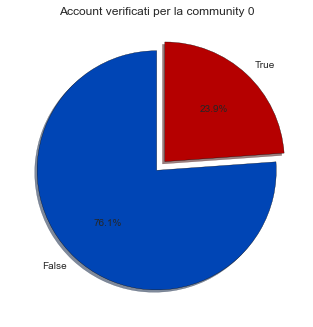

In [43]:
verified_pie_chart("0", metadata)
verified_pie_chart("1", metadata)

In [47]:
default_pie_chart('0', metadata, 'DefaultImage')
default_pie_chart('1', metadata, 'DefaultImage')

Index(['username', 'created', 'defaultProfile', 'DefaultImage', 'description',
       'numLikes', 'numFollowers', 'numFollowing', 'numGroups', 'location',
       'numStatuses', 'verified', 'community', 'placeholder'],
      dtype='object')

No handles with labels found to put in legend.


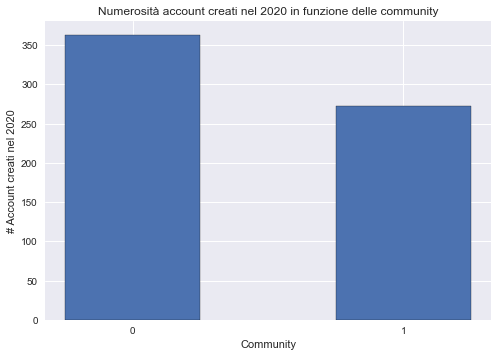

In [154]:
filt = (metadata['created'] >= '2020')
metadata_2020 = metadata.loc[filt]
plot_hist_2020(metadata_2020)

In [156]:
metadata.columns

Index(['username', 'created', 'defaultProfile', 'DefaultImage', 'description',
       'numLikes', 'numFollowers', 'numFollowing', 'numGroups', 'location',
       'numStatuses', 'verified', 'community', 'sentiment', 'placeholder'],
      dtype='object')

In [223]:
def delete_url(tweet):
    for i in range(len(tweet)):
        tweet[i] = re.sub(r'\b(http:|www\.)(?:[^\s,.!?]|[,.!?](?!\s))+', '', tweet[i])
        tweet[i] = re.sub(r"http\S+", '', tweet[i])
        tweet[i] = re.sub(r'http:\\*/\\*/.*?\s', '', tweet[i])
        tweet[i] = re.sub(r'https:\\*/\\*/.*?\s', '', tweet[i])
        tweet[i] = re.sub(r"twitter.(\w+)", ' ', tweet[i], flags=re.MULTILINE)
        tweet[i] = re.sub(r'://(?:[^\s,.!?]|[,.!?](?!\s))+', '', tweet[i])
        tweet[i] = re.sub(r"://", ' ', tweet[i], flags=re.MULTILINE)
        tweet[i] = re.sub(r"/(\w+)", ' ', tweet[i], flags=re.MULTILINE)
        tweet[i] = re.sub(r"#", '', tweet[i])
        tweet[i] = re.sub(r'陈秋实(?:[^\s,.!?]|[,.!?](?!\s))+', '', tweet[i])
        tweet[i] = re.sub(r'full(?:[^\s,.!?]|[,.!?](?!\s))+', '', tweet[i])
        tweet[i] = re.sub(r'utm_source(?:[^\s,.!?]|[,.!?](?!\s))+', '', tweet[i])
        tweet[i] = re.sub(r'utm_medium=(?:[^\s,.!?]|[,.!?](?!\s))+', '', tweet[i])
        tweet[i] = re.sub(r'=social(?:[^\s,.!?]|[,.!?](?!\s))+', '', tweet[i])
        tweet[i] = re.sub(r'=web&(?:[^\s,.!?]|[,.!?](?!\s))+', '', tweet[i])
        tweet[i] = re.sub(r'utm_campaign(?:[^\s,.!?]|[,.!?](?!\s))+', '', tweet[i])
        tweet[i] = re.sub(r'.html', '', tweet[i])
    return tweet

def word_cloud(words):
    
    papers_mask = np.array(Image.open("./twitter_mask.png"))
    stopwords = set(STOPWORDS)
    stopwords.update(['NoDescription', 'https co'])
    wordcloud = WordCloud(width=800, height=400, stopwords=stopwords, background_color="white", 
                          mode="RGBA", max_words=1000, mask = papers_mask).generate(words)

    image_colors = ImageColorGenerator(papers_mask)
    
    return wordcloud, image_colors

def preprocessing(summary):
    summary = delete_url(summary)
    tokening = TweetTokenizer(strip_handles=True, reduce_len=True)
    summary_series = pd.Series(summary)
    summary_tokenized = summary_series.apply(tokening.tokenize)
    for sentence in range(len(summary_tokenized)):
        not_number = [token for token in summary_tokenized[sentence] if not token.isdigit()]
        summary_tokenized[sentence] = not_number
    summary_tokenized_stop = summary_tokenized.apply(lambda x: [item for item in x if item not in {'NoDescription', 'We', 'New'}])
    list_done = list(summary_tokenized_stop)
    list_done = [item for sublist in list_done for item in sublist]
    return list_done

def summary_word_cloud(meta_df):
    summary = list()
    cont = 0
    
    for _, row in meta_df.iterrows():
        summary.append(row['description'])
    summ_clean = preprocessing(summary)
            
    wordcloud, colors = word_cloud(' '.join(summ_clean))
    fig, ax = plt.subplots(figsize=[20,20])
        
    # plt.title(title)
    ax.axis("off")
    ax.imshow(wordcloud.recolor(color_func=colors), interpolation="bilinear")
    #title.replace(" ", "_")
    #save_img(title)
    plt.show()

In [224]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.tokenize import TweetTokenizer
import re

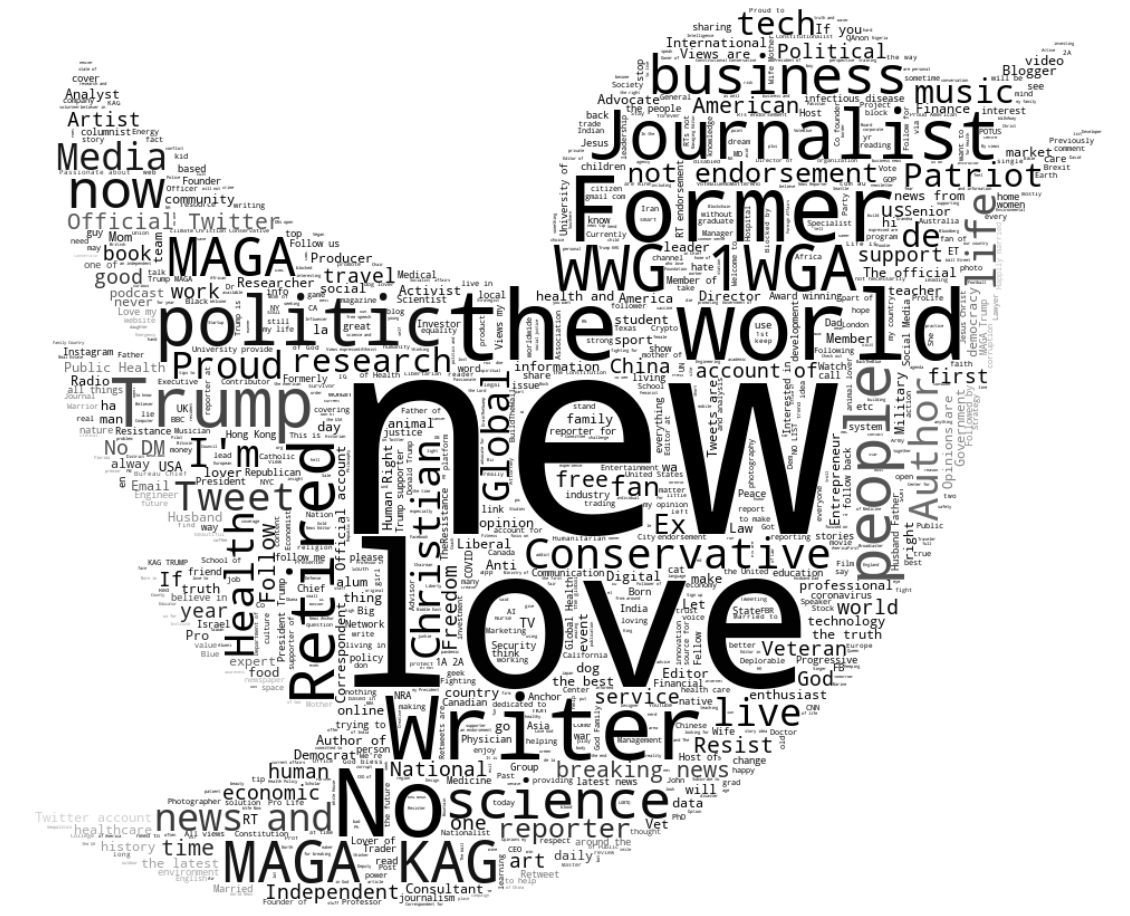

In [225]:
summary_word_cloud(metadata)

## Vax

In [ ]:
os.chdir('/Users/villons/Desktop/echo-chamers/src/data/vax_no_vax')

In [ ]:
vax_compact = nx.read_gml('Graph/Final_Graph_vax.gml')
vax_complete = nx.read_gml('Graph/Final_DiGraph_Vax.gml')

In [ ]:
print(nx.info(vax_complete))

In [ ]:
vaccination_df = create_graph_df(vax_compact)

In [ ]:
print(nx.info(vax_complete))

#### Pie chart community membership

In [ ]:
community_pie_chart(vax_compact, 'weightComm', 'Vaccinazioni con approccio strutturale', 'Vaccination')
community_pie_chart(vax_compact, 'sentimentComm', 'Vaccinazioni con approccio sentiment e strutturale', 'Vaccination')
community_pie_chart(vax_compact, 'topicComm', 'Vaccinazioni con approccio topic e strutturale', 'Vaccination')
community_pie_chart(vax_compact, 'hybridComm', 'Vaccinazioni con approccio ibrido', 'Vaccination')

#### Distribution plot different approach

In [ ]:
plot_sentiment_distribution(vax_compact, 'Vaccination', vaccination_df)

#### Topic talking

In [ ]:
topic_distribution(vaccination_df, 'Vaccination')

#### Degree distribution

In [ ]:
plot_degree_distribution(vax_complete, 'Vaccination', 0)